# A Variational Quantum Eigensolver in Qiskit >= 1.0
*(Tested with Qiskit 1.2)*

In [1]:
# Quantum Chemistry
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.units import DistanceUnit as UnitsType

# Simulation
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2
from qiskit_ibm_runtime.fake_provider import FakeBelemV2

# Ansätze
from qiskit.circuit.library import EfficientSU2
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock

# VQE
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_algorithms.optimizers import SPSA

# Tools
from qiskit_algorithms.minimum_eigensolvers import MinimumEigensolverResult
import numpy as np
import matplotlib.pyplot as plt

## Molecule and Hamiltonian

In [2]:
# The BeH2 molecule
driver = PySCFDriver(
		    atom="""H 0, 0.0, 0.0
                    H  0.74, 0.0, 0.0
            """,
		    basis='sto3g',
		    charge=0,
		    spin=0,
		    unit=UnitsType.ANGSTROM)

In [3]:
# Generating the Electronic Structure Problem
molecule_problem = driver.run()

In [4]:
# The Hartree-Fock energy
molecule_problem.reference_energy

-1.1167593073964257

### Active Space Transformation

In [5]:
# Reducing the problem to the active space containing the 2 electrons in the 2 spatial orbitals
active_space_transformer = ActiveSpaceTransformer(num_electrons=2, num_spatial_orbitals=2)
reduced_molecule_problem = active_space_transformer.transform(molecule_problem)

### Mapping: Parity with 2-qubit tappering

In [6]:
# Obtaining the second quantized Hamiltonian
second_q_hamiltonian = reduced_molecule_problem.second_q_ops()[0]

In [7]:

jordanwigner_mapper = JordanWignerMapper()
# Applying the Parity Mapping
qubit_op = jordanwigner_mapper.map(second_q_hamiltonian)
print(qubit_op)

SparsePauliOp(['IIII', 'IIIZ', 'IIZI', 'IZII', 'ZIII', 'IIZZ', 'IZIZ', 'ZIIZ', 'YYYY', 'XXYY', 'YYXX', 'XXXX', 'IZZI', 'ZIZI', 'ZZII'],
              coeffs=[-0.81217061+0.j,  0.17141283+0.j, -0.22343154+0.j,  0.17141283+0.j,
 -0.22343154+0.j,  0.12062523+0.j,  0.16868898+0.j,  0.16592785+0.j,
  0.04530262+0.j,  0.04530262+0.j,  0.04530262+0.j,  0.04530262+0.j,
  0.16592785+0.j,  0.17441288+0.j,  0.12062523+0.j])


### Target energy: exact diagnolization
This is not necessary for the VQE, but it is good to have a wel defined target energy value for testing.

In [8]:
# Exact diagonalization of the mapped Hamiltonian's matrix
exact_min_eigenvalue = np.linalg.eigvalsh(qubit_op.to_matrix())[0]
print(f'{exact_min_eigenvalue = }')

exact_min_eigenvalue = -1.8523881735695837


In [9]:
# Getting the exact ground energy by interpreting the result in the context of the reduced molecule problem
def interpret_exp_val(exp_val, problem):
    # Wrapping the expectation value in MinimumEigensolverResult
    sol = MinimumEigensolverResult()
    sol.eigenvalue = np.real(exp_val)
    # Interpreting the result
    return  problem.interpret(sol).total_energies[0]

exact_ground_energy = interpret_exp_val(exact_min_eigenvalue, reduced_molecule_problem)
print(f'{exact_ground_energy = }')

exact_ground_energy = -1.1372838344885026


## VQE

### The Ansatz

**Efficient SU2**

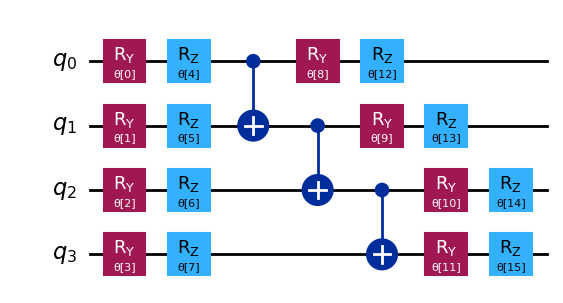

In [10]:
ansatz = EfficientSU2(num_qubits=qubit_op.num_qubits, entanglement='linear', reps=1)
ansatz.decompose().draw('mpl')

### The Cost Function

**Backend and Ansatz transpliation**

In order to run the ansatz' quantum circuit on a quantum computer, we must re-express it in terms of quantum gates that are natively supported by the target quantum computer. That is, decomposing the initial logical quantum gates into native physical quantum gates, as well as respecting the physical qubits' conectivity which may require reassigning qubits and re-routing two-qubit gates. This process of converting a logical circuit into a physical one is called transpilation or compilation.

First we define the target quantum backend, which may be a real quantum hardware or a simulator. In this case, we use Qiskit Aer's AerSimulator. Then we prepare a pass manager that will perform the transpilation. We set the target backend to the simulator and specify that we require no optimization in our specific case. The transpiled quantum circuit is the Instruction Set Architecture (ISA) circuit. Finally, the qubit layout of the transpiled ansatz is applied to the Hamiltonian observable, aligning the qubits of the observable with those of the ansatz. This is important as we must measure the correct observables on the correct qubits.

In [11]:
# Creating a backend
# In this case, it is an SVS simulator
backend = AerSimulator()

# Creating the pass manager that transpiles the ansatz
pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

# Transpiling the ansatz
# ISA stands for "Instruction Set Architecture"
isa_ansatz = pm.run(ansatz)

# Applying the layout of the ISA ansatz to the Hamiltonian observable
# This ensures that the observables qubits are the same as the ansatz qubits
isa_observables = qubit_op.apply_layout(isa_ansatz.layout)

In [12]:
# Using the Estimator primitive with the previously defined backend
estimator = EstimatorV2(mode=backend)

# Defining the energy cost function
def energy_cost_function(params):
    # Run the job and get the eigenvalue result
    estimator_job = estimator.run(
        [
        (isa_ansatz, isa_observables, params)
        ]
        )
    estimator_exp_val = estimator_job.result()[0].data.evs
    # Return the interpreted energy value
    return interpret_exp_val(estimator_exp_val, reduced_molecule_problem)

energy_cost_function(np.random.rand(ansatz.num_parameters))

0.5343151029092633

**Callback function for the optimizer**

In [13]:
# Results list to store the energy values
results = []

# The callback function runs after each iteration
def optimizer_callback(ne, params, value, step, accepted):
    global results
    results.append(value)
    # Printing intermediate results
    print(f'Iteration {len(results):03d}  -  Energy = {value}')

**Defining the optimizer: SPSA**

In [14]:
# Defining the SPSA optimizer
optimizer = SPSA(maxiter=150, callback=optimizer_callback)

**Calibration phase**

In [15]:
print('    CALIBRATING SPSA...')

# Defining random initial parameters
initial_params = np.random.rand(ansatz.num_parameters)

# Calibrating the SPSA optimizer
learning, pert = optimizer.calibrate(energy_cost_function, initial_params)

# Setting the calibrated learning rate and perturbation series
optimizer.learning_rate = learning
optimizer.perturbation = pert

print('    CALIBRATED.')

    CALIBRATING SPSA...
    CALIBRATED.


**The VQE**

In [16]:
print('    START VQE...')
# Running the VQE algorithm
# It is the SPSA algorithm that uses a quantum cost function
result = optimizer.minimize(energy_cost_function, initial_params)
print('    VQE FINISHED.')

    START VQE...
Iteration 001  -  Energy = 0.49317484066198825
Iteration 002  -  Energy = 0.48889018097096026
Iteration 003  -  Energy = 0.22393498112291782
Iteration 004  -  Energy = 0.11501257089497585
Iteration 005  -  Energy = -0.12212245193263771
Iteration 006  -  Energy = -0.11622308623188182
Iteration 007  -  Energy = -0.13848712469855806
Iteration 008  -  Energy = -0.1386700244134682
Iteration 009  -  Energy = -0.22659204716352943
Iteration 010  -  Energy = -0.28181712081022314
Iteration 011  -  Energy = -0.26390944820480877
Iteration 012  -  Energy = -0.28426675231510434
Iteration 013  -  Energy = -0.3901434993077333
Iteration 014  -  Energy = -0.4449287002892546
Iteration 015  -  Energy = -0.4195422178171577
Iteration 016  -  Energy = -0.4266602419318317
Iteration 017  -  Energy = -0.43762402601435246
Iteration 018  -  Energy = -0.43474651323337055
Iteration 019  -  Energy = -0.5861419679764119
Iteration 020  -  Energy = -0.6563208798552498
Iteration 021  -  Energy = -0.7043

In [17]:
# Storing the final energy and parameters
energy_result, parameters_result = result.fun, result.x

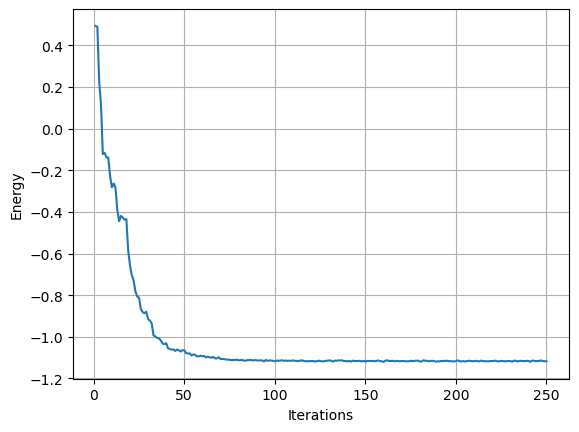

In [18]:
# plotting the energy convergence
plt.plot(range(1, len(results) + 1), results)
plt.xlabel('Iterations')
plt.ylabel('Energy')

plt.grid()
plt.show()

___